# GRPM Dataset Builder 2.0 (LitVar2 Patch)

This notebook is designed to retrieve genetic polymorphism data from multiple sources. It uses the LitVar API to extract polymorphisms for each human gene within the LitVar2 database along with all associated PubMed Identifiers (PMIDs). These PMIDs are then employed as queries on PubMed to obtain MEDLINE data (parsed though the 'nbib' package). All collected data are ultimately consolidated into a single CSV file, known as the "GRPM Dataset", which serves as the primary source against which MeSH term queries can be launched to retrieve genes and polymorphisms associated with specific contexts.  

**Updates** : 

The GRPM Dataset available on Zenodo is a snapshot of [LitVar1](https://www.ncbi.nlm.nih.gov/CBBresearch/Lu/Demo/LitVar/help.html). LitVar1 is now <u>**deprecated**</u> and has been fully replaced by [LitVar2](https://www.ncbi.nlm.nih.gov/research/litvar2/). This module 
([Dataset Builder](https://github.com/johndef64/GRPM_system/blob/main/GRPM_01_dataset_builder.ipynb)) has been updated to retrieve data from LitVar2. The subsequent modules in the pipeline remain functional and can be tested using the original version of the GRPM Dataset available on Zenodo.

# Import Requirements and Functions

In [1]:
import importlib
import subprocess

try:
    importlib.import_module('pygrpm')
except ImportError:
    subprocess.check_call(["pip", "install", "git+https://github.com/johndef64/GRPM_system.git"])

from pygrpm import *
from pygrpm.data_retrieval import *
from pygrpm.utils import *

# requirements = ['nbib', 'requests', "biopython", "matplotlib", "bs4", "pandas"]
# check_and_install_requirements(requirements)


# Import Requirements ================
import os
import ast
import time
import nbib
import pandas as pd
import requests as rq
import matplotlib.pyplot as plt
from datetime import datetime
from io import StringIO
from Bio import Entrez

Entrez.email = "your_email@example.com"

request_counter = 0
gene_counter = 0

C:\Users\Utente\anaconda3\envs\newenv\lib\site-packages\sentence_transformers\cross_encoder\CrossEncoder.py:13: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm, trange


# Get required data from Zenodo

In [2]:
if not os.path.exists('human_genes.csv'):
    get_from_zenodo('human_genes.csv')

# Load Human Gene list ---------------------------------
h_genes= pd.read_csv('human_genes.csv', index_col=0)

protein_coding_genes = h_genes[h_genes['Type code']=="PCG"  ].reset_index(drop=True)
IG_TR_genes          = h_genes[h_genes['Type code']=="IG_TR"].reset_index(drop=True)
RNA_genes            = h_genes[h_genes['Type code']=="RNA"  ].reset_index(drop=True)
pseudo_genes         = h_genes[h_genes['Type code']=="PSD"  ].reset_index(drop=True)
misc_genes           = h_genes[h_genes['Type code']=="MISC" ].reset_index(drop=True)

#First: protein coding genes:
protein_coding_genes_list = protein_coding_genes['Gene name'].dropna().tolist()
RNA_genes_list            = RNA_genes['Gene name'].dropna().tolist()
pseudo_genes_list         = pseudo_genes['Gene name'].dropna().tolist()

print('Ensembl genes:')
print('protein_coding_genes_list =',len(protein_coding_genes_list))
print('RNA_genes_list            =',len(RNA_genes_list))
print('pseudo_genes_list         =',len(pseudo_genes_list))

Ensembl genes:
protein_coding_genes_list = 19318
RNA_genes_list            = 11452
pseudo_genes_list         = 9866


# Whole genome forecast

In [3]:
#Statistics based on 150 random genes:
time_sleep = 0.4
runtime_gene = 6.36 #sec/gene
genes_hour = 566 #genes/hour
request_counter_gene = 4.25 #request/gene (with base sleep (0.4))
sleep_request_base = 0.4 #time sleep each request
sleep_request_overnight_plus = 1.1 # for an overnight job

print('Forecast:')
max_genes = int(10000/request_counter_gene)
table_size_db_gene = 0.496 #MB
table_size_gene = 0.397 #MB
png_size_db_gene = 0.47 #KB

#Forecast:
genes = protein_coding_genes_list
nruntime = len(genes) * runtime_gene
#print('runtime, '+str(len(genes)), nruntime)
nrequest_counter = len(genes) * request_counter_gene

tempo_ore = round(nruntime/3600, 2)
tempo_ore_overnight = round((nruntime+(sleep_request_overnight_plus*len(genes)))/3600, 2)

print('max genes/day= ',max_genes)
print('for',str(int(len(genes))),'genes:')
print('    request counter =', nrequest_counter,'requests')
print('    whole genome runtime =', tempo_ore,'hours')
print('    whole genome runtime overnight =', tempo_ore_overnight)

db_table_size = len(genes) * table_size_gene
print('    db table size', round(db_table_size,2),'MB')

Forecast:
max genes/day=  2352
for 19318 genes:
    request counter = 82101.5 requests
    whole genome runtime = 34.13 hours
    whole genome runtime overnight = 40.03
    db table size 7669.25 MB


# Load Human Genes

In [4]:
# Load Human Gene list ---------------------------------

# create gene lists:
protein_coding_genes_list = protein_coding_genes['Gene name'].dropna().tolist()
rna_genes_list = RNA_genes['Gene name'].dropna().tolist()
pseudo_genes_list = pseudo_genes['Gene name'].dropna().tolist()


# Split job packages:----------------------------------

# (1) protein coding genes:
gene_range = int(len(protein_coding_genes_list)/18)
genes = [protein_coding_genes_list[i * gene_range : (i + 1) * gene_range] for i in range(0, 18)]
pcg_chunks = genes[:18]

# (2) RNA genes:
rna_gene_range = int(len(rna_genes_list)/5)
genes = [rna_genes_list[i * rna_gene_range : (i + 1) * rna_gene_range] for i in range(0, 8)]
rna_chunks = genes[:5]

# (3) pseudo genes:
pseudo_gene_range = int(len(pseudo_genes_list)/2)
genes = [rna_genes_list[i * pseudo_gene_range : (i + 1) * pseudo_gene_range] for i in range(0, 8)]
pseudo_chunks = genes[:2]

print('protein_coding_genes',len(protein_coding_genes['Gene name'].dropna()),
      '\nIG_TR_genes',len(IG_TR_genes['Gene name'].dropna()),
      '\nRNA_genes',len(RNA_genes['Gene name'].dropna()),
      '\npseudo_genes',len(pseudo_genes['Gene name'].dropna()),
      '\nmisc_genes',len(misc_genes['Gene name'].dropna()))

print('\nrecommended job lenght for pcg:',int(len(protein_coding_genes_list)/18))

protein_coding_genes 19318 
IG_TR_genes 641 
RNA_genes 11452 
pseudo_genes 9866 
misc_genes 22

recommended job lenght for pcg: 1073


# Set options and import building dataset

In [5]:
# set main path:--------------------------------
db_path = 'grpm_dataset/'
if not os.path.exists(db_path):
    os.makedirs(db_path)
#------------------------------------------------


#import checkpoint datasets:
time_a = datetime.now()
if os.path.isfile(db_path+'/grpm_dataset.parquet'):
    complete_df = pd.read_parquet(db_path+'/grpm_dataset.parquet', engine='auto', columns=None)
    restart = True
else:
    complete_df = pd.DataFrame()
    restart = False

if os.path.isfile(db_path+'/grpm_nbib.parquet'):
    grpm_nbib = pd.read_parquet(db_path+'/grpm_nbib.parquet', engine='auto', columns=None)

else:
    grpm_nbib = pd.DataFrame()
time_b = datetime.now()

print('time load',time_b-time_a)

## check saved data:
if os.path.isfile(db_path+'/grpm_dataset.parquet'):
    gene_db_count =  complete_df.gene.nunique()
    print('complete_df gene count:',gene_db_count,'on', len(protein_coding_genes_list))
    if gene_db_count >= 15519:
        print('grpm db already contains all available genes on litvar1')

    print('\ngrpm_dataset.csv size'  ,round(os.path.getsize(db_path+'/grpm_dataset.parquet')/(1024*1024),3),'MB')
    print('grpm_nbib.csv size',round(os.path.getsize(db_path+'/grpm_nbib.parquet')/(1024*1024),3),'MB')
    print('memory_usage_complete_df'     ,round(complete_df.memory_usage().sum()/(1024*1024),3))
    print('memory_usage_complete_nbib_df',round(grpm_nbib.memory_usage().sum()/(1024*1024),3))
else:
    print('empty dataset')
    print('empty dataset')

time load 0:00:00.004001
empty dataset
empty dataset


# Run Job

## Set gene-range for this job

In [6]:
# Set the gene list ----------------

#1. Set gene-range [whole genome build]
gene_chunk = pcg_chunks[0]
            # pcg_chunks[0:17]
            # rna_chunks[0:4]
            # pseudo_chunks[0:1]

# run a sample?
run_sample = simple_bool('Do you want to run a chunk sample for testing?')
if run_sample:
    sample_size = int(input('sample size? \nnum:'))
    print(f'sample size: {sample_size}')


#2. place here your custom gene list [custom build]
if not run_sample:
    custom_genes = ['APOA1', 'FFC1', 'ERH', 'USP53']
    custom_list = simple_bool('Do you want to run the custom gene list?')
else:
    custom_list = False

#if stucked, store skipped_genes and run custom list later:
skipped_genes =  []

# Set save interval checkpoint frequency
checkpoint = 10
print(f'saving checkpoint each {checkpoint} genes')

sample size: 2
saving checkpoint each 10 genes


## Run Job

In [7]:
# set options:--------------------------------
save_plot           = False
save_studytype_data = False
save_accessory_data = False


# Run Job -------------------------
if run_sample:
    genes = pd.Series(gene_chunk).sample(sample_size).reset_index(drop=True).to_list()
    restart = False
else:
    genes = pd.Series(gene_chunk).to_list()

if restart:
    restart_from = complete_df.gene.nunique()
    gene_start = restart_from
    print('search restarted from '+str(restart_from))
else:
    gene_start = 0

if custom_list:
    genes = custom_genes
    gene_start = 0


#=========================================================================
time_start = datetime.now()
print('Start at ',time_start)

for gene in genes[gene_start:]:

    #LitVar2 "Variants for Gene" API request
    if request_counter > 9950:
        print('Request limit reached. Please, wait \'till tomorrow!')

    time_alpha = datetime.now()
    url = "https://www.ncbi.nlm.nih.gov/research/litvar2-api/variant/search/gene/" + gene
    response = (rq.get(url)).text

    # Build Dataframe from response
    data = "[" + transform_string(response) + "]"
    df = pd.read_json(StringIO(data))

    if 'rsid' in df.columns and len(df.rsid)>1:
        # Creating a df without the clingen entry
        dfb = df[['_id','pmids_count','rsid']]
        dfa = dfb[~dfb['_id'].str.contains('@CA')].drop_duplicates().reset_index(drop=True)
        dfn = dfa.dropna(subset=['rsid'])

        #handle = Entrez.esearch(db="snp", term=gene)
        #record = Entrez.read(handle)
        #request_counter += 1

        NCBI_dbSNP = 'na' #record["Count"]
        lit2_variant = len(dfa['_id'].drop_duplicates())
        lit2_variant_norsid = len(dfa.loc[df['rsid'].isna()])
        lit2_rsid = len(dfn.rsid.drop_duplicates())

        # remove rsid with pmid_count = 1
        df2 = dfn.loc[df.pmids_count !=1]
        lit2_rsid_f = len(df2)

        # accessory data
        dfsort = df.sort_values(by='pmids_count',ascending=False).reset_index(drop=True)
        df2sort = df2.sort_values(by='pmids_count',ascending=False).reset_index(drop=True)
      

        for rsid in df2.rsid[0:1]:
            url="https://www.ncbi.nlm.nih.gov/research/litvar2-api/variant/get/litvar@"+rsid+"%23%23/publications"
            response = (rq.get(url)).text
            response_dict = ast.literal_eval(response)
            rsid_pubs = pd.DataFrame({key: pd.Series(value) for key, value in response_dict.items()})
            
            #Display-------------------------------------------------------
            pmid_mesh_spost = pd.DataFrame(rsid_pubs)
            if 'pmids' in pmid_mesh_spost.columns and len(pmid_mesh_spost.pmids_count)>1:
                lit1_rsid = 0
    
                # Creating the simple list [rsid-pmid]========================
                rsidpmid = pmid_mesh_spost[['pmids']].copy()
                rsidpmid['rsid'] = str(rsid)
                rsidpmid['pmids'] = rsidpmid['pmids'].astype('str')
                
                #report data:
                lit1_rsid_pmid = len(rsidpmid)
                lit1_pmid = len(rsidpmid.drop_duplicates(subset='pmids'))
    
    
                #### [MODULE: groupby.describe]
                # applicare groupby ad rsidpmid per avere tabella pmid count
                rsidpmidcount = rsidpmid.groupby('rsid').describe().reset_index()
                rsidpmidcount.columns = rsidpmidcount.columns.to_flat_index()
                new_column_names = ['rsid', 'pmid_count', 'pmid_unique','pmid_top','pmid_freq']
                rsidpmidcount.columns = new_column_names
                rsidpmidcountf = rsidpmidcount[['rsid','pmid_unique']]
    
                #report data:-------------------------------------------------------------
                lit1_rsid_f = len(rsidpmidcountf[rsidpmidcountf.pmid_unique!=1])
                lit1_rsid_m = len(rsidpmidcountf[rsidpmidcountf.pmid_unique==1])
    
                rsidpmidcountfsort = rsidpmidcountf.sort_values('pmid_unique',ascending=False).reset_index(drop=True)
    
    
                #Filter pmid for rsid with pmid>1------------------------------------------
                outless = rsidpmidcountfsort[rsidpmidcountfsort.pmid_unique>1]
                #creare una mask isin su rsidpmid con outless.rsid
                mask = rsidpmid['rsid'].isin(outless.rsid)
                rsidpmidless = rsidpmid[mask]
                lit1_pmid_f = len(rsidpmidless.pmids.drop_duplicates())


                # PubMed Request =====================================================
                
                # PubMed queries Build:
                pmid_l = rsidpmid.pmids.drop_duplicates().tolist()
                query = build_pubmed_query(pmid_l, limit = 1300)
                
                ## Get PubMed data:     
                time1 = datetime.now()
                pages = ((len(pmid_l)//200)+1)+1
                if len(pmid_l) % 200 == 0:
                    pages = pages -1
                fullnbib = str()
                for d in query:
                    for i in range(1, pages):
                        nbib01 = GetPubmedData(i, d)                        
                        fullnbib += nbib01
                        request_counter += pages
                        time.sleep(1.5)
    
                time2 = datetime.now()
                timestamp = time2.strftime('%Y%m%d%H%M%S')
                runtime = time2-time1
                duration = str(runtime).split('.')[0]
                hours, minutes, seconds = duration.split(':')
                compact_duration = '{}:{}:{}'.format(hours, minutes, seconds)
    
                # nbib parsing:
                timea = datetime.now()
                ref = nbib.read(fullnbib)
                dfbib = pd.DataFrame(ref)
                if 'descriptors' in dfbib.columns and len(dfbib['descriptors'])>1:
                    dfbibdes = dfbib[['pubmed_id','descriptors']].dropna().reset_index(drop=True)
                    nbib_objects = len(dfbib)
                    nbib_objects_withdescriptors = len(dfbibdes)
                    #print('nibib objects:',nbib_objects)
                    #print('nibib objects with descriptors:',len(dfbibdes))
                    timeb = datetime.now()
                    #print('runtime:', timeb-timea)
    
                    # Statistics:
                    pubmed_pmid_nbib = len(dfbib.pubmed_id.drop_duplicates())
                    pubmed_pmid_nbib_yesmesh = len(dfbibdes.pubmed_id.drop_duplicates())
                    pubmed_pmid_nbib_nomesh = len(dfbib.pubmed_id.drop_duplicates())-len(dfbibdes.pubmed_id.drop_duplicates())
    
                    # refine MESH
                    pmid_mesh = []
                    for i in range(len(dfbibdes)):
                        for mesh in dfbibdes['descriptors'][i]:
                            out = dfbibdes['pubmed_id'][i], mesh
                            pmid_mesh.append(out)
                    MESH = pd.DataFrame(pmid_mesh).rename(columns={0: 'pmid',1:'mesh'})
    
                    # dataframe parsing splitting three fields
                    MESH_split =[]
                    for i in range(len(MESH)):
                        mg = MESH.mesh[i].get('descriptor')
                        mg2 = MESH.mesh[i].get('qualifier')
                        mg3 = MESH.mesh[i].get('major')
                        mgg = MESH.pmid[i], mg, mg2, mg3
                        MESH_split.append(mgg)
    
                    dfmesh = pd.DataFrame(MESH_split).rename(columns={0: 'pmid',1:'mesh',2:'qualifier',3:'major'}).drop_duplicates()
    
                    # statistics
                    pubmed_pmidmesh = len(dfmesh[['pmid','mesh']].drop_duplicates())
                    pubmed_mesh_qualifier_major = len(MESH.mesh.drop_duplicates())
                    pubmed_mesh = len(dfmesh.mesh.drop_duplicates())
    
                    pmidmesh = dfmesh[['pmid','mesh']].drop_duplicates()
                    pmidmesh['pmid'] = pmidmesh['pmid'].astype(str) #convert pmid type in str
    
    
                    #Analyze enrichment with groupby.describe method-------------------------------
                    #Add rsid column con merge
                    rsidpmid = rsidpmid.rename(columns={"pmids": "pmid"})
                    rspmidmesh_merge = pd.merge(pmidmesh, rsidpmid, on= 'pmid', how='inner').drop_duplicates().reindex(columns=['pmid', 'rsid', 'mesh'])
                    #rspmidmesh_merge['pmid'] = rspmidmesh_merge['pmid'].astype(str)
    
                    ### groupby.describe analysis by mesh
                    meshrspmidmerge_count = rspmidmesh_merge.groupby('mesh').describe().reset_index()
                    meshrspmidmerge_count.columns = meshrspmidmerge_count.columns.to_flat_index()
                    #to handle generate df.groupby.describe, convert Multicolumn to single column https://datascientyst.com/flatten-multiindex-in-pandas/
                    new_column_names = ['mesh', 'pmid-count', 'pmid-unique','pmid-top','pmid-freq','rsid-count', 'rsid-unique','rsid-top','rsid-freq']
                    meshrspmidmerge_count.columns = new_column_names
    
                    meshrspmidmerge_count_short = meshrspmidmerge_count[['mesh','pmid-unique','rsid-unique']]

    
                    # add frequency
                    totalpmid_count = len(pmidmesh.pmid.drop_duplicates())
                    meshrspmidmerge_count_short_freq = meshrspmidmerge_count_short.copy()
                    meshb_frq = meshrspmidmerge_count_short_freq.loc[:,'pmid-unique'].astype(float)/totalpmid_count
                    meshrspmidmerge_count_short_freq.loc[:,'mesh frequency'] = round(meshb_frq,3)#*100
                    meshrspmidmerge_count_short_freq_sort = meshrspmidmerge_count_short_freq.sort_values(by='pmid-unique',ascending=False).reset_index(drop=True)
    
                    top10mesh_all = meshrspmidmerge_count_short_freq_sort['mesh'][:10].tolist()
                    #display(meshrspmidmerge_count_short_freq_sort.head(20))
    
                    ### groupby.describe analysis by rsid------------------
                    rspmidmeshmerge_count = rspmidmesh_merge.groupby('rsid').describe().reset_index()
                    rspmidmeshmerge_count.columns = rspmidmeshmerge_count.columns.to_flat_index()
                    new_column_names = ['rsid', 'pmid-count', 'pmid-unique','pmid-top','pmid-freq','mesh-count', 'mesh-unique','mesh-top','mesh-freq']
                    rspmidmeshmerge_count.columns = new_column_names
    
                    rsid_pmid10 = len(rspmidmeshmerge_count[rspmidmeshmerge_count['pmid-unique']>10])
                    rsid_pmid50 = len(rspmidmeshmerge_count[rspmidmeshmerge_count['pmid-unique']>50])
                    rsid_pmid100 = len(rspmidmeshmerge_count[rspmidmeshmerge_count['pmid-unique']>100])
                                        
    
                    rspmidmeshmerge_count_short = rspmidmeshmerge_count[['rsid','pmid-unique','mesh-unique']]
                    rspmidmeshmerge_count_short_sort = rspmidmeshmerge_count_short.sort_values(by='pmid-unique', ascending= False).reset_index(drop=True)
                    top10rsid_all = rspmidmeshmerge_count_short_sort['rsid'].iloc[:10].tolist()

                    # create a scatter plot-----------------------------------------
                    if save_plot:
                        plot_retrieval_data(meshrspmidmerge_count_short_freq_sort, timestamp, db_path, gene)
 
                    # GET STUDY TYPE from NBIB----------------------------------------
                    if save_studytype_data:
                        get_studytype_data(ref, gene, db_path)
    
    
                    #SAVE DATA========================================================
                    timestamp = time2.strftime('%Y%m%d%H%M%S')
                    # save accessory data:
                    if save_accessory_data:
                        dfsort[["_id","rsid","pmids_count"]].to_csv(db_path+'/'+gene+'_litvar2_variants4gene.csv')
                        rsidpmid.to_csv(db_path+'/'+gene+'_litvar1_rsids2pmids.csv') #lit1 [rsid-pmid]
                        #rsidpmidcountfsort #lit1 pmid count
    
                        meshrspmidmerge_count_short_freq_sort.to_csv(db_path+'/'+gene+'_mesh_pmidrsid_count.csv')
    
                    #complete_df with concat:
                    dfmesh['pmid'] = dfmesh['pmid'].astype(str)
                    rsidpmid['pmid'] = rsidpmid['pmid'].astype(str)
    
                    # add a rsid-merger to dfmesh
                    gene_rsidpmidmesh = pd.merge(rsidpmid, dfmesh, on='pmid')
                    gene_rsidpmidmesh['gene'] = gene
    
                    gene_df = pd.DataFrame(gene_rsidpmidmesh)
                    complete_df = pd.concat([complete_df, gene_rsidpmidmesh])
    
                    #grpm_nbib with concat:
                    dfbib['gene'] = gene
                    grpm_nbib = pd.concat([grpm_nbib, dfbib])
    
                    # save checkpoint----------------------
                    if genes.index(gene) > 1 and genes.index(gene) % checkpoint == 0:
                        save_checkpoint(complete_df, grpm_nbib, db_path)
                    else:
                        pass

    
                    # Build REPORT-------------------------------------------------
                    time_omega = datetime.now()
                    full_runtime = time_omega - time_alpha
                    print(gene + '_runtime:', full_runtime)
                    nbib_seconds = runtime.total_seconds()
                    total_seconds = full_runtime.total_seconds()
                    full_runtime_str = str(full_runtime).split('.')[0]
    
                    report = {'type': h_genes.loc[h_genes['Gene name'] == gene, 'Type code'].values[0],
                              'ncbi_dbsnp': NCBI_dbSNP,
                              'lit2_variant': lit2_variant,
                              'lit2_variant_norsid': lit2_variant_norsid,
                              'lit2_rsid': lit2_rsid,
                              'lit2_rsid_plus1': lit2_rsid_f,
                              'lit1_rsid': lit1_rsid,
                              #'lit1_raw_pmid': lit1_raw_pmid,
                              #'lit1_rsid_pmid': lit1_rsid_pmid,
                              'lit1_rsid_pmid_plus1': lit1_rsid_f,
                              #lit1_rsid_pmid=1': lit1_rsid_m,
                              'lit1_pmid': lit1_pmid,
                              'lit1_pmid_pmid_plus1': lit1_pmid_f,
                              'pubmed_pmid_query': len(pmid_l),
                              'nbib_objects': nbib_objects,
                              'nbib_objects_withdescriptors': nbib_objects_withdescriptors,
                              'pubmed_pmid': pubmed_pmid_nbib,
                              'pubmed_pmid_withmesh': pubmed_pmid_nbib_yesmesh,
                              #'pubmed_pmid_nomesh':pubmed_pmid_nbib_nomesh,
                              'pubmed_pmidmesh': pubmed_pmidmesh,
                              'pubmed_mesh_qualifier_major': pubmed_mesh_qualifier_major,
                              'pubmed_mesh': pubmed_mesh,
                              'rsid_pmid10': rsid_pmid10,
                              'rsid_pmid50': rsid_pmid50,
                              'rsid_pmid100': rsid_pmid100,
                              'top10mesh_all': str(top10mesh_all),
                              'top10rsid_all': str(top10rsid_all),
                              'pubmed_runtime': duration,
                              'total_runtime': full_runtime_str,
                              'time_stamp': time2
                              }
    
                    df_report = pd.DataFrame(report, index=[gene])#.transpose()
    
                    # generate fist report.csv
                    if os.path.isfile(db_path+'/grpm_report.parquet'):
                        #dfL = pd.read_csv(db_path+'/grpm_report.csv', index_col=0)
                        dfL = pd.read_parquet(db_path+'/grpm_report.parquet')#, index_col=0)
                        dfL = pd.concat([dfL, df_report])#, axis=1)
                        dfL.to_parquet(db_path+'/grpm_report.parquet')
                    else:
                        df_report.to_parquet(db_path+'/grpm_report.parquet')  # solo la prima volta
    
                    #Update gene values
                    #grpm_report = pd.read_csv(db_path+'/grpm_report.csv', index_col=0)
                    grpm_report =  pd.read_parquet(db_path+'/grpm_report.parquet', engine='pyarrow')
                    if gene + '.1' in grpm_report.columns:
                        grpm_report = grpm_report.drop(columns=gene)
                        grpm_report = grpm_report.rename(columns={gene + '.1': gene})
                        grpm_report.to_csv(db_path+'/grpm_report.csv')
                        print(gene,'already in db')
                else:
                    print(gene + ' no descriptors in NBIB')
                    time.sleep(0.8)
                    pass
            else:
                print(gene + ' no results on litvar2 (rsid2pmids)')
                time.sleep(0.8)
                pass
    else:
        print(gene + ' no results on litvar2 (gene2pmidcount)')
        pass

    if request_counter > 9000:
        dada = 2
        #print('Allert! Reaching pubmed request limit')
    if request_counter > 9950:
        #print('Request limit reached. Wait \'till tomorrow!')
        time_finish = datetime.now()
        time_batch = time_finish - time_start
        time_batch_str = str(time_batch).split('.')[0]
        #print('time batch:', time_batch_str)
        #break

# Save Data
save_checkpoint(complete_df, grpm_nbib, db_path)

# Print Job Statistics
time_finish = datetime.now()
time_batch = time_finish - time_start
time_batch_str = str(time_batch).split('.')[0]
print('\nJob Statistics:')
print('gene batch:', len(genes))
print('time batch:', time_batch_str)
print('runtime/gene:', time_batch/len(genes))
print('request_counter:', request_counter,' (limit: 10.000/day)')
gene_counter += len(genes)
print('requests/gene:', request_counter/gene_counter)
print(time_finish)

### notes:
# LIMITS PubMed Programming Utilities (PMU)
# 10 requests/second
# 10,000 requests/day

Start at  2025-02-16 21:40:42.746147
ADAMTS12_runtime: 0:00:03.634034
LILRA6_runtime: 0:00:03.634001
saved checkpoint

Job Statistics:
gene batch: 2
time batch: 0:00:07
runtime/gene: 0:00:03.803499
request_counter: 4  (limit: 10.000/day)
requests/gene: 2.0
2025-02-16 21:40:50.353145


In [8]:
print('GRPM report:')
report = pd.read_parquet(db_path+'/grpm_report.parquet', engine='pyarrow').reset_index()
display(report.head())
dataset = pd.read_parquet(db_path+'/grpm_dataset.parquet', engine='pyarrow')

print('\nGRPM genes gathered:', len(dataset.gene.drop_duplicates()))
#display(dataset.gene.drop_duplicates())

print('\nNBIB table:')
nbib_data = pd.read_parquet(db_path+'/grpm_nbib.parquet', engine='pyarrow' )
display(nbib_data.head())

GRPM report:


,index,type,ncbi_dbsnp,lit2_variant,lit2_variant_norsid,lit2_rsid,lit2_rsid_plus1,lit1_rsid,lit1_rsid_pmid_plus1,lit1_pmid,...,pubmed_mesh_qualifier_major,pubmed_mesh,rsid_pmid10,rsid_pmid50,rsid_pmid100,top10mesh_all,top10rsid_all,pubmed_runtime,total_runtime,time_stamp
0,ADAMTS12,PCG,na,954,4,943,346,0,1,2,...,33,28,0,0,0,"['Genetic Variation', 'Humans', 'Age Factors',...",['rs997598'],0:00:01,0:00:03,2025-02-16 21:40:46.286157
1,LILRA6,PCG,na,292,1,291,132,0,1,14,...,132,106,1,0,0,"['Humans', 'Mutation', 'Male', 'High-Throughpu...",['rs8105096'],0:00:02,0:00:03,2025-02-16 21:40:49.770180



GRPM genes gathered: 2

NBIB table:


,gene,pubmed_id,citation_owner,nlm_status,last_revision_date,electronic_issn,linking_issn,journal_volume,journal_issue,publication_date,...,revised_time,accepted_time,pubmed_time,medline_time,entrez_time,pii,doi,publication_status,print_issn,pages
0,ADAMTS12,25326100,NLM,MEDLINE,2022-12-07,1744-4292,1744-4292,10,10,2014 Oct 16,...,NaT,NaT,2014-10-19 06:00:00,2015-02-11 06:00:00,2014-10-19 06:00:00,None,10.15252/msb.20145114,epublish,1744-4292,754
1,ADAMTS12,24058506,NLM,MEDLINE,2021-10-21,1932-6203,1932-6203,8,9,2013,...,NaT,2013-07-23,2013-09-24 06:00:00,2014-06-04 06:00:00,2013-09-24 06:00:00,PONE-D-13-18467,10.1371/journal.pone.0073950,epublish,None,e73950
0,LILRA6,37012232,NLM,MEDLINE,2024-05-15,2041-1723,2041-1723,14,1,2023 Apr 3,...,NaT,2023-03-20,2023-04-04 06:00:00,2023-04-05 06:42:00,2023-04-03 23:13:00,37547,10.1038/s41467-023-37547-0,epublish,None,1851
1,LILRA6,29118384,NLM,MEDLINE,2022-12-07,2045-2322,2045-2322,7,1,2017 Nov 8,...,NaT,2017-10-23,2017-11-10 06:00:00,2019-07-19 06:00:00,2017-11-10 06:00:00,15183,10.1038/s41598-017-15183-1,epublish,None,14992
2,LILRA6,36075891,NLM,PubMed-not-MEDLINE,2023-01-11,2054-345X,2054-345X,9,1,2022 Sep 8,...,2022-07-18,2022-07-20,2022-09-09 06:00:00,2022-09-09 06:01:00,2022-09-08 23:14:00,208,10.1038/s41439-022-00208-7,epublish,2054-345X,31


# Show saved report

In [9]:
# Visualize grpm_report.csv
grpm_report = pd.read_parquet(db_path+'/grpm_report.parquet', engine='pyarrow').reset_index()

# Sort Values
grpm_report.sort_values(by='lit1_pmid',ascending = False)

,index,type,ncbi_dbsnp,lit2_variant,lit2_variant_norsid,lit2_rsid,lit2_rsid_plus1,lit1_rsid,lit1_rsid_pmid_plus1,lit1_pmid,...,pubmed_mesh_qualifier_major,pubmed_mesh,rsid_pmid10,rsid_pmid50,rsid_pmid100,top10mesh_all,top10rsid_all,pubmed_runtime,total_runtime,time_stamp
1,LILRA6,PCG,na,292,1,291,132,0,1,14,...,132,106,1,0,0,"['Humans', 'Mutation', 'Male', 'High-Throughpu...",['rs8105096'],0:00:02,0:00:03,2025-02-16 21:40:49.770180
0,ADAMTS12,PCG,na,954,4,943,346,0,1,2,...,33,28,0,0,0,"['Genetic Variation', 'Humans', 'Age Factors',...",['rs997598'],0:00:01,0:00:03,2025-02-16 21:40:46.286157


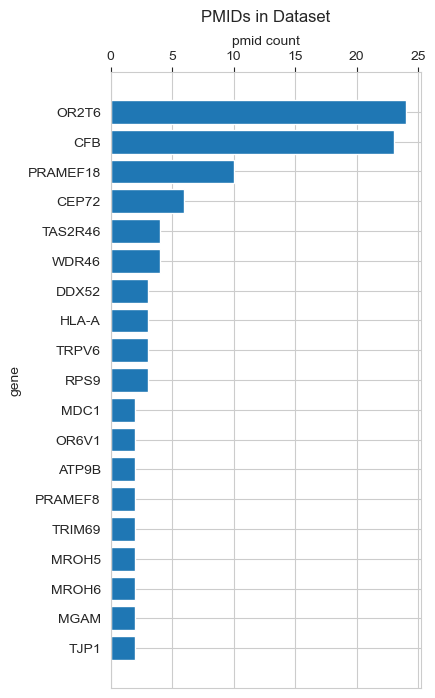

In [14]:
# Show Bar Graph
grpm_report_sort = grpm_report.sort_values(by= 'pubmed_pmid',ascending=False)

x = grpm_report_sort['index'].iloc[:40]
y = grpm_report_sort['pubmed_pmid'].iloc[:40]
plt.figure(figsize=(4, 8))
plt.title('PMIDs in Dataset', loc='center',pad=10)

plt.barh(x,y)
plt.gca().invert_yaxis()
plt.tick_params(axis='x', which='both', top=True, bottom=False, labeltop=True, labelbottom=False)
#plt.xlabel('pmid count', position=(0.5, 1.08))
plt.ylabel('gene')
plt.xlabel('pmid count', position=(0.5, 1.08))
ax = plt.gca()
ax.xaxis.set_label_position('top')
#plt.savefig('PMID_filtered.png',dpi=300, bbox_inches = "tight")
plt.show()

# Debugging

## debugging: litvar data

In [ ]:
# if stucked check 'data' variable:
# replace manually malformed lines
data

## debugging: nbib

In [ ]:
#NBIB PROBLEM SOLVER---------------------------------
# replace malformed lines
fullnbib= fullnbib.replace('2007/09/31','2007/09/30') # <= some dates are mispelled in pubmed
ref = nbib.read(fullnbib)
dfbib = pd.DataFrame(ref)
dfbib

NBIB PROBLEM SOLVER [History] ---------------------------------
with open('nbib report '+gene+'.txt', 'w', encoding='utf-8') as file:
    file.write(fullnbib)
with open('nbib report '+gene+'_FIXED.txt', 'r', encoding='utf-8') as file:
    fullnbib = file.read() # --> not work

# extras

## Eutils: get study type

In [ ]:
check_and_install_module('biopython')
from Bio import Entrez
Entrez.email = "your_email@example.com"

In [ ]:
### EUTILS GET STUDY TYPE MODULE
#https://biopython.org/docs/1.76/api/Bio.Entrez.html
def get_study_type(pmids):
    Entrez.email = 'your_email@your_domain.com'
    handle = Entrez.esummary(db='pubmed', id=','.join(pmids), retmode='xml')
    records = Entrez.parse(handle)
    study_types = []
    for record in records:
        article_types = record['PubTypeList']
        if 'Randomized Controlled Trial' in article_types:
            study_types.append('Randomized Controlled Trial')
        elif 'Controlled Clinical Trial' in article_types:
            study_types.append('Controlled Clinical Trial')
        elif 'Cohort Studies' in article_types:
            study_types.append('Cohort Study')
        elif 'Case-Control Studies' in article_types:
            study_types.append('Case-Control Study')
        elif 'Review' in article_types:
            study_types.append('Review')
        elif 'Clinical Trial' in article_types:
            study_types.append('Clinical Trial')
        elif 'Meta-Analysis' in article_types:
            study_types.append('Meta-Analysis')
        elif 'Multicenter Study' in article_types:
            study_types.append('Multicenter Study')
        else:
            study_types.append('Unknown')
    return study_types

pmidlist = list(pmidmesh['pmid'].drop_duplicates())
genepmids_str = list(map(str, pmidlist))
study_type = get_study_type(genepmids_str)
pmids_studytype = pd.DataFrame(list(zip(genepmids_str, study_type)), columns=[gene + '_PMID', 'study type'])
request_counter += 1

#study type count:
pmids_studytype_count = pmids_studytype.groupby('study type').describe().reset_index()
pmids_studytype_count.columns = pmids_studytype_count.columns.to_flat_index()
new_column_names = ['study_type', 'pmid-count', 'pmid-unique', 'pmid-top', 'pmid-freq']
pmids_studytype_count.columns = new_column_names
pmids_studytype_countsort = pmids_studytype_count.sort_values(by='pmid-count', ascending=False)